# Misclassification Analysis

This notebook contains unpolished, base analysis of the misclassifications of the models developed. A much easier to understand version of misclassification analysis is provided in the writeup.

In [ ]:
import pandas as pd  
import numpy as np

from sklearn.model_selection import train_test_split

import os
import sys
sys.path.insert(0, '../src')
import config
import pipelines as pipe
from preprocess import quantify_text

In [ ]:
def get_classific_type(act_pred_diff):

    if act_pred_diff == 0:
        return 'Correct'
    elif act_pred_diff > 0:
        return 'FN'
    else:
        return 'FP'
    

def get_misclassifications(pipeline_no):

    df = pd.read_csv(config.TRAINING_DATA)
    target = config.TARGET
    text_feat = config.TEXT

    if int(pipeline_no) < 4:

        X = df[text_feat]
        y = df[target].values
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42, stratify=y
        )

        # get the estimator i.e pipeline
        estimator = pipe.pipe_dict[pipeline_no]

    elif int(pipeline_no) == 4:

        print("Going ahead with this hoping you have rechecked `pipelines.py` w.r.t features considered!")

        # add more features
        df = quantify_text(df, text_feat)

        X = df.drop([target], axis=1)
        y = df[target].values
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42, stratify=y
        )

        # get the estimator i.e pipeline
        estimator = pipe.pipe_dict[pipeline_no]

    else:

        print("That pipeline has not yet been created")
        return None

    # fit estimator
    estimator.fit(X_train, y_train)
    print("Fitting done.")

    # predict
    preds = estimator.predict(X_test)

    # check for misclassification
    temp = pd.DataFrame(y_test)
    temp = temp.reset_index(drop=True)
    temp.columns = ['actual']
    temp['preds'] = preds
    temp['actual_pred_diff'] = temp['actual'] - temp['preds']
    temp['classification_type'] = temp['actual_pred_diff'].apply(get_classific_type)

    # make diagnostic dataframe
    X_test = pd.DataFrame(X_test)
    X_test = X_test.reset_index(drop=True)
    temp = pd.concat([X_test, temp], axis=1)
    temp = temp.reset_index(drop=True)

    # store the data
    name = 'classification_diagnostics_' + pipeline_no + '.csv'
    path = os.path.join("../data", name)
    temp.to_csv(path, index=False)

    print('Done.')

In [ ]:
for i in ['1', '2', '3', '4']:
    get_misclassifications(i)

Fitting done.
Done.
Fitting done.
Done.
Fitting done.
Done.
Going ahead with this hoping you have rechecked `pipelines.py` w.r.t features considered!
Fitting done.
Done.


## Exploring Misclassifications

**File format:** classification\_diagnostics\_{pipeline_no}.csv

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_label(val):

    if val == 0:
        return 'Not an attack'
    else:
        return 'Personal attack'

def get_cm(df, normalize='true'):

    return confusion_matrix(df.actual, df.preds)

def classification_rep(df, labels):

    print (classification_report(df.actual, df.preds, labels=labels))

def diagnostics(pipe):

    path = '../data/classification_diagnostics_' + str(pipe) + '.csv'
    df = pd.read_csv(path)
    df['actual'] = df.actual.apply(get_label)
    df['preds'] = df.preds.apply(get_label)

    # get confusion matrix
    labels = ['Not an attack', 'Personal attack']
    cm = get_cm(df)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=True)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    # classification report
    classification_rep(df, labels)

    return df

### Confusion Matrices

                 precision    recall  f1-score   support

  Not an attack       0.89      0.95      0.92      2356
Personal attack       0.77      0.59      0.67       644

       accuracy                           0.87      3000
      macro avg       0.83      0.77      0.80      3000
   weighted avg       0.87      0.87      0.87      3000



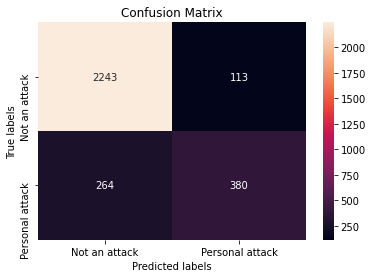

In [ ]:
df_1 = diagnostics(1)

                 precision    recall  f1-score   support

  Not an attack       0.90      0.91      0.91      2356
Personal attack       0.66      0.63      0.64       644

       accuracy                           0.85      3000
      macro avg       0.78      0.77      0.77      3000
   weighted avg       0.85      0.85      0.85      3000



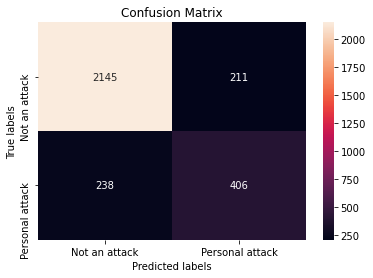

In [ ]:
df_2 = diagnostics(2)

                 precision    recall  f1-score   support

  Not an attack       0.93      0.86      0.89      2356
Personal attack       0.60      0.75      0.67       644

       accuracy                           0.84      3000
      macro avg       0.76      0.81      0.78      3000
   weighted avg       0.86      0.84      0.84      3000



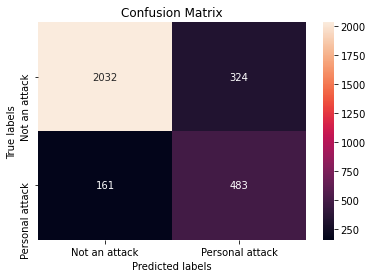

In [ ]:
df_3 = diagnostics(3)

                 precision    recall  f1-score   support

  Not an attack       0.93      0.88      0.90      2356
Personal attack       0.62      0.75      0.68       644

       accuracy                           0.85      3000
      macro avg       0.77      0.81      0.79      3000
   weighted avg       0.86      0.85      0.85      3000



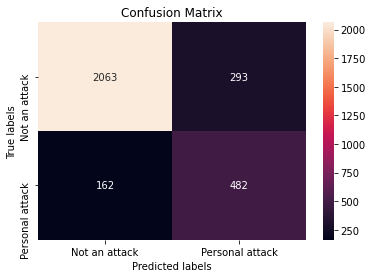

In [ ]:
df_4 = diagnostics(4)

### Misclassified Texts

In [ ]:
from wordcloud import WordCloud

In [ ]:
fn = df_1[df_1.classification_type == 'FN']
fp = df_1[df_1.classification_type == 'FP']
corr = df_1[df_1.classification_type == 'Correct']

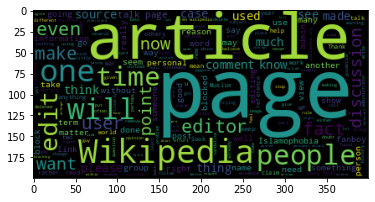

In [ ]:
words = ' '.join(fn['text'])
wc = WordCloud().generate(words)
plt.imshow(wc)

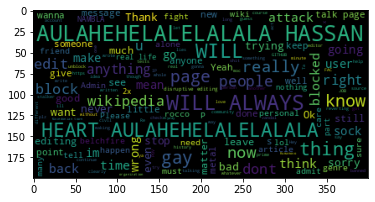

In [ ]:
words = ' '.join(fp['text'])
wc = WordCloud().generate(words)
plt.imshow(wc)

In [ ]:
weird_word = 'AULAHEHELALELALALA'

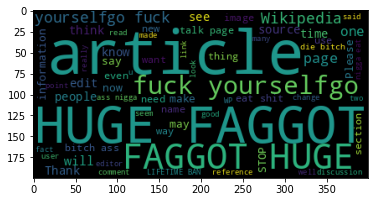

In [ ]:
words = ' '.join(corr['text'])
wc = WordCloud().generate(words)
plt.imshow(wc)

In [ ]:
def weird_in(text):

    if 'AULAHEHELALELALALA' in text:
        return 1
    return 0

def block_in(text):

    if 'block' in text:
        return 1
    return 0

df_1['weird'] = df_1['text'].apply(weird_in)
df_1['block'] = df_1['text'].apply(block_in)

In [ ]:
df_1.block.value_counts()

0    2777
1     223
Name: block, dtype: int64

In [ ]:
df_1[(df_1.block == 1)]

,text,actual,preds,actual_pred_diff,classification_type,weird,block
11,I didn't ask for your opinion on this. The blo...,Personal attack,Personal attack,0,Correct,0,1
18,"Go fuck yourself asshole. By the way, this IP ...",Personal attack,Personal attack,0,Correct,0,1
19,"Dear Mokele,\nYou have no right to tell people...",Personal attack,Personal attack,0,Correct,0,1
23,**Thank you for the note. I have no plan to re...,Not an attack,Not an attack,0,Correct,0,1
33,you bitch why didn't you block kew gardens he ...,Personal attack,Personal attack,0,Correct,0,1
...,...,...,...,...,...,...,...
2960,back again.. 7 more contributions after the 24...,Not an attack,Not an attack,0,Correct,0,1
2977,"He writes them by hand, mails to ghost blogger...",Not an attack,Not an attack,0,Correct,0,1
2981,You shouldn't of blocked user editor on wheels...,Personal attack,Personal attack,0,Correct,0,1
2982,Theringi's vandalism \n\nYou ought to post to...,Not an attack,Not an attack,0,Correct,0,1


In [ ]:
df_1.head()

,text,actual,preds,actual_pred_diff,classification_type,weird,block
0,Whoever wrote the Plot \nI feel terrible for ...,Personal attack,Not an attack,1,FN,0,0
1,As an afterthought: you called me a 'newbie' w...,Not an attack,Not an attack,0,Correct,0,0
2,Hi \n\nI'm not going to challenge you or any...,Not an attack,Not an attack,0,Correct,0,0
3,I don't recall claiming anyone was a bully? Th...,Not an attack,Not an attack,0,Correct,0,0
4,Hi Moonriddengirl. Thanks for making the artic...,Not an attack,Not an attack,0,Correct,0,0


### Most frequent words in all comments

In [ ]:
import texthero as hero
from texthero import stopwords
import textdistance as td

In [ ]:
df = pd.read_csv("../data/train.csv")
df.head()

,id,attack,text
0,348598183,0,which may contain more details
1,61527923,1,"Regardless, the point is that I am willing to ..."
2,325989249,0,Lede \nI'm reverting (again) the additions to...
3,197250961,0,I just came to this page and was wondering why...
4,116195271,1,It's worth having an illustration. The Type 2...


In [ ]:
# text preprocessing pipeline
df['clean_text'] = df['text'].pipe(
    hero.lowercase
)

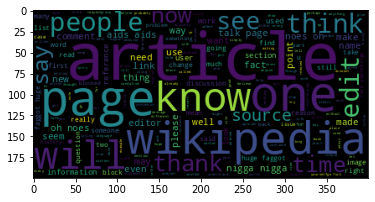

In [ ]:
words = ' '.join(df['clean_text'])
wc = WordCloud().generate(words)
plt.imshow(wc)

In [ ]:
token_frequencies = pd.DataFrame(hero.top_words(df['clean_text'], normalize=False))
token_frequencies['word'] = token_frequencies.index
token_frequencies.columns = ['frequency', 'word']
token_frequencies.frequency = round(token_frequencies.frequency, 3)
token_frequencies = token_frequencies.reset_index(drop=True)

# unique tokens
tokens = list(token_frequencies.word)

In [ ]:
tokens[:10]

['the', 'to', 'and', 'of', 'a', 'you', 'i', 'is', 'that', 'in']

In [ ]:
token_frequencies[:5]

,frequency,word
0,46599,the
1,27856,to
2,22330,and
3,21610,of
4,20624,a


In [ ]:
#hero.tfidf(df.clean_text, return_feature_names=True)
# too many words! tf-idf won't work now

In [ ]:
profane_list = open(config.PROFANITY_LIST, 'r').readlines()
profane_list = [w.replace('\n', '') for w in profane_list]
profane_list[:5]

['abbo', 'abo', 'abortion', 'abuse', 'addict']

In [ ]:
td.levenshtein.normalized_similarity('motherfucker', 'mothafjer')

0.5833333333333333

In [ ]:
"""
word1 = []
word2 = []
similarity = []
for i in tokens:
    for j in tokens:
        if i!=j:
            word1.append(i)
            word2.append(j)
            similarity.append(td.levenshtein.normalized_similarity(i, j))
"""

'\nword1 = []\nword2 = []\nsimilarity = []\nfor i in tokens:\n    for j in tokens:\n        if i!=j:\n            word1.append(i)\n            word2.append(j)\n            similarity.append(td.levenshtein.normalized_similarity(i, j))\n'

In [ ]:
# remove all tokens appearing less than or equal to 5 times
less5_occurence = token_frequencies[token_frequencies.frequency <= 5]
token_frequencies = token_frequencies[token_frequencies.frequency > 5]
#more1000_occurence = token_frequencies[token_frequencies.frequency >= 1000]
#less5_occurence = token_frequencies[token_frequencies.frequency <= 5]

In [ ]:
# create stopwords
# words with less than 5 occurences in total
# Top 100 words with most frequencies
token_stopwords = set(list(less5_occurence.word) + list(token_frequencies.word.head(100)))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=94079369-10d1-4c3e-b7f5-859473c4f3a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>